In [42]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.tokenize import TweetTokenizer
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vinicius/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
query = """select comment.body, Author.username from Comment
join Author ON Author.id = Comment.author_id
where Comment.author_id = 'hir54' OR Comment.author_id = '4am7b'"""

conn = sqlite3.connect('Reddit.db')

key_users = pd.read_sql_query(query, conn)
key_users

,body,username
0,"Rest in peace Leo.\n\nYou've given us so much,...",Supermunch2000
1,GROND,Supermunch2000
2,Extraordinária!\n\n😂🤣😂🤣😂🤣😂🤣😂🤣,Supermunch2000
3,Confirmado: PCO é o partido dos isentões centr...,Supermunch2000
4,Certamente vai fiscalizar se um desses caminhõ...,Supermunch2000
...,...,...
1995,"Lá no rio grande do sul, tem atleta Brasileiro...",squiercg
1996,"Uai, mas tá lá certo? Comentei no sentido esté...",squiercg
1997,Tá certo.,squiercg
1998,"Galera na moral, não tem uma postagem dessa pa...",squiercg


In [3]:
vect = TfidfVectorizer(tokenizer=TweetTokenizer().tokenize)
vect.fit(key_users.body)
tfidf_dict = dict(zip(vect.get_feature_names(), vect.idf_))

/home/vinicius/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/vinicius/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [4]:
from gensim.models import Word2Vec

tknzr = TweetTokenizer()
stop_words = set(nltk.corpus.stopwords.words('portuguese'))

texts = key_users.body.str.lower()
#texts = texts.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

X = texts.apply(tknzr.tokenize)

emb = Word2Vec(X, vector_size=100, min_count=1, workers=8)

In [5]:
def embedding_transform(X, tfidf, w2v):
    docs_vectors = pd.DataFrame()
    for doc in X:
      temp = pd.DataFrame()
      for word in doc:
        try:
          word_vec = tfidf[word] * w2v.wv[word]
          temp = pd.concat([temp, pd.DataFrame([word_vec])], ignore_index = True)
        except:
          pass
      doc_vector = temp.mean()
      docs_vectors = pd.concat([docs_vectors, pd.DataFrame([doc_vector])], ignore_index = True)
    return docs_vectors

In [6]:
X_emb = embedding_transform(X.iloc, tfidf_dict, emb)
X_emb

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.276404,0.769898,0.122254,-0.157070,0.448485,-1.738909,-0.155398,2.309579,-0.943661,-1.094476,...,1.064891,0.015145,0.011052,0.067410,1.409366,0.945423,-0.061558,-1.227203,-0.220930,0.387565
1,-0.044713,0.054955,-0.063117,0.010204,-0.010664,-0.004304,0.050943,0.041268,-0.000967,-0.009862,...,-0.029321,-0.058130,0.005844,0.021964,-0.036215,-0.026016,-0.015222,-0.051247,-0.008174,0.051521
2,-0.296662,0.820872,0.168003,-0.203128,0.421590,-1.746832,-0.154623,2.314332,-0.999089,-1.108761,...,1.083027,-0.013744,-0.056708,0.038399,1.473763,0.928143,-0.043381,-1.217977,-0.196192,0.408588
3,-0.458600,1.241970,0.237844,-0.232642,0.668852,-2.767211,-0.193138,3.645895,-1.546393,-1.750385,...,1.691724,0.069236,-0.007857,0.101631,2.275900,1.455058,-0.083840,-1.943503,-0.308428,0.581181
4,-0.389539,1.081075,0.182419,-0.205024,0.570105,-2.401796,-0.179688,3.163470,-1.321931,-1.530525,...,1.455415,0.064238,0.019202,0.066629,1.993128,1.259686,-0.050830,-1.674155,-0.268564,0.498846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.454583,1.249801,0.231132,-0.223924,0.660585,-2.772314,-0.181007,3.664006,-1.535146,-1.749753,...,1.677313,0.087282,0.008472,0.084816,2.295333,1.464517,-0.063204,-1.937758,-0.309414,0.583451
1996,-0.462598,1.307862,0.239438,-0.236300,0.687921,-2.896212,-0.186411,3.826875,-1.595544,-1.834238,...,1.748355,0.086923,0.009705,0.083525,2.393486,1.529406,-0.062250,-2.022971,-0.324479,0.607039
1997,-0.470520,1.262680,0.262788,-0.213107,0.678941,-2.824666,-0.170879,3.711703,-1.554319,-1.801709,...,1.683223,0.061891,0.025692,0.090481,2.288976,1.498693,-0.073057,-1.959328,-0.311106,0.607361
1998,-0.419568,1.165883,0.208945,-0.211181,0.629934,-2.592913,-0.166656,3.409163,-1.428889,-1.626948,...,1.566736,0.069630,0.006490,0.085836,2.141008,1.363977,-0.065103,-1.803192,-0.293102,0.550940


In [7]:
indexes_na = list(X_emb[X_emb.isna().any(axis=1)].index)
indexes_na

[]

In [8]:
X_emb.drop(indexes_na, inplace=True)
bigdata = key_users.reset_index().drop(indexes_na)

In [37]:
pca = PCA(n_components=50)
pca_data = pca.fit_transform(X_emb)
tsne = TSNE(perplexity=np.sqrt(len(bigdata)), 
            learning_rate = 'auto', 
            n_iter=1000,
            n_components=2,
            random_state=42)
tsne_data = tsne.fit_transform(pca_data)

/home/vinicius/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [38]:
emb_data = pd.DataFrame({"Attr1":tsne_data[:,0],
                        "Attr2":tsne_data[:,1],
                        'body':key_users.body,
                        "author":key_users.username})

/home/vinicius/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attr1', ylabel='Attr2'>

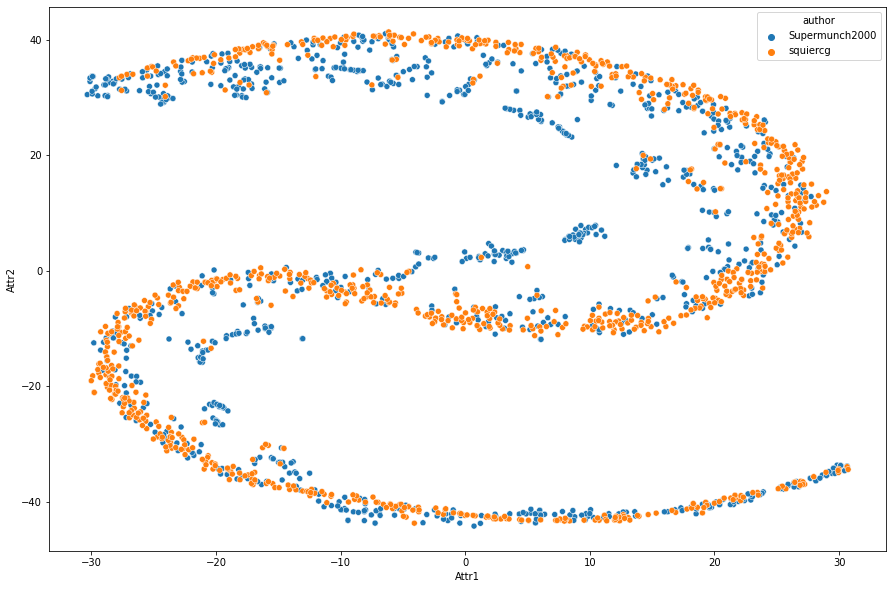

In [39]:
to_plot = emb_data
plt.figure(figsize=(15,10))
sns.scatterplot("Attr1", "Attr2", hue="author", data=to_plot)

In [41]:
import plotly.express as px
import plotly

fig = px.scatter(emb_data, 
                 x="Attr1", 
                 y="Attr2", 
                 hover_name='author',
                 hover_data = ['body'],
                 color="author", 
                 symbol='author')
plotly.offline.plot(fig, filename='fig_author.html')
#fig.show(renderer="browser")

'fig_author.html'

In [46]:
vect = TfidfVectorizer().fit(emb_data.body)
X = vect.transform(emb_data.body)
y = emb_data.author

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

Supermunch2000       0.93      0.56      0.70       256
      squiercg       0.67      0.96      0.79       244

      accuracy                           0.75       500
     macro avg       0.80      0.76      0.75       500
  weighted avg       0.81      0.75      0.74       500

